In [1]:
## RUN TO MAKE FILES

# Import necessary libraries
from pandas import read_csv, Series, DataFrame, concat
import numpy as np
import pandas as pd
import re
from plotnine import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Get games data from CSV
dataGames = pd.read_csv('steam_games.csv')

# Preprocess the game data
dataGames = dataGames[['name','recent_reviews','all_reviews','release_date','publisher','popular_tags','game_details','genre']]
dataGames['name'] = dataGames['name'].fillna('')
# Define column names for user data
column_names = ['user_id', 'game_name', 'behavior', 'value', 'Column5']
dataUsers = pd.read_csv('steam-200k.csv', header=None, names=column_names)


# remove spaces and special character from game name in both dataset
for i, row in dataGames.iterrows():
    clean = re.sub('[^A-Za-z0-9]+', '', row["name"])
    clean = clean.lower()
    dataGames.at[i, 'ID'] = clean

for i, row in dataUsers.iterrows():
    clean = re.sub('[^A-Za-z0-9]+', '', row["game_name"])
    clean = clean.lower()
    dataUsers.at[i, 'ID'] = clean
    
    
# Preprocess the user data


dataUsers['value'] = pd.to_numeric(dataUsers['value'], errors='coerce').fillna(0)
dataUsers['purchase'] = (dataUsers['value'] > 0).astype(int)
dataUsers['play'] = (dataUsers['value'] > 0).astype(int)
dataUsers = dataUsers.drop(['behavior', 'Column5'], axis=1)
dataUsers = dataUsers.rename(columns={'value': 'hours'})
dataUsers = dataUsers.drop_duplicates(subset=['user_id', 'game_name'], keep='last')
dataUsers.loc[dataUsers['hours'] == 1, 'play'] = 0
dataUsers.to_csv('steam_users_purchase_play.csv', index=False)

# Split user data into training and test sets
train_dataUsers, test_dataUsers = train_test_split(dataUsers, test_size=0.2, random_state=42)

# Save training and test sets to CSV files
train_dataUsers.to_csv('steam_user_train.csv', index=False)
test_dataUsers.to_csv('steam_user_test.csv', index=False)

# Create ID columns for game and user datasets
dataGames["ID"] = ""
dataUsers["ID"] = ""

# Filter games dataset based on user data
gameArrayUsers = dataUsers["ID"].unique()
criteriaTest = dataGames['ID'].isin(gameArrayUsers)
usedGames = dataGames[criteriaTest]

# Function to clean data by removing spaces
def clean_data(x):
    if isinstance(x, str):
        return x.replace(" ", "")
    else:
        return x

# Apply data cleaning to selected columns in usedGames DataFrame
usedGames['recent_reviews'] = usedGames['recent_reviews'].apply(clean_data)
usedGames['all_reviews'] = usedGames['all_reviews'].apply(clean_data)
usedGames['release_date'] = usedGames['release_date'].apply(clean_data)
usedGames['publisher'] = usedGames['publisher'].apply(clean_data)
usedGames['popular_tags'] = usedGames['popular_tags'].apply(clean_data)
usedGames['game_details'] = usedGames['game_details'].apply(clean_data)
usedGames['genre'] = usedGames['genre'].apply(clean_data)

# Create additional columns with mixed information
usedGames["genre_publisher"] = usedGames['genre'] + usedGames['publisher']
usedGames["genre_popular_tags"] = usedGames['genre'] + usedGames['popular_tags'] + usedGames['publisher']
usedGames["genre_popular_tags_game_details"] = usedGames['genre'] + usedGames['popular_tags'] + usedGames['game_details']
usedGames["genre_publisher_developer_game_details"] = usedGames['genre'] + usedGames['publisher'] + usedGames['game_details']

# Remove duplicates from the usedGames DataFrame
usedGames.drop_duplicates("name")

# Save the cleaned usedGames DataFrame to a new CSV file
usedGames.to_csv('cleaned_usedGames.csv', index=False)

import pandas as pd

# Load the full dataset
full_dataset = pd.read_csv('cleaned_usedGames.csv')

# Columns to keep
columns_to_keep = ['name', 'ID', 'genre_publisher', 'genre_popular_tags', 
                   'genre_popular_tags_game_details', 'genre_publisher_developer_game_details']

# Keeping only the specified columns
reduced_dataset = full_dataset[columns_to_keep]

# Save the reduced dataset to a new CSV file
reduced_dataset.to_csv('reduced_cleaned_usedGames.csv', index=False)



C:\Users\trifo\AppData\Local\Temp\ipykernel_32420\3239689508.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\trifo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
C:\Users\trifo\anaconda3\Lib\site-packages\plotnine\positions\position.py:229: PlotnineWarning: position_dodge requires non-overlapping x intervals


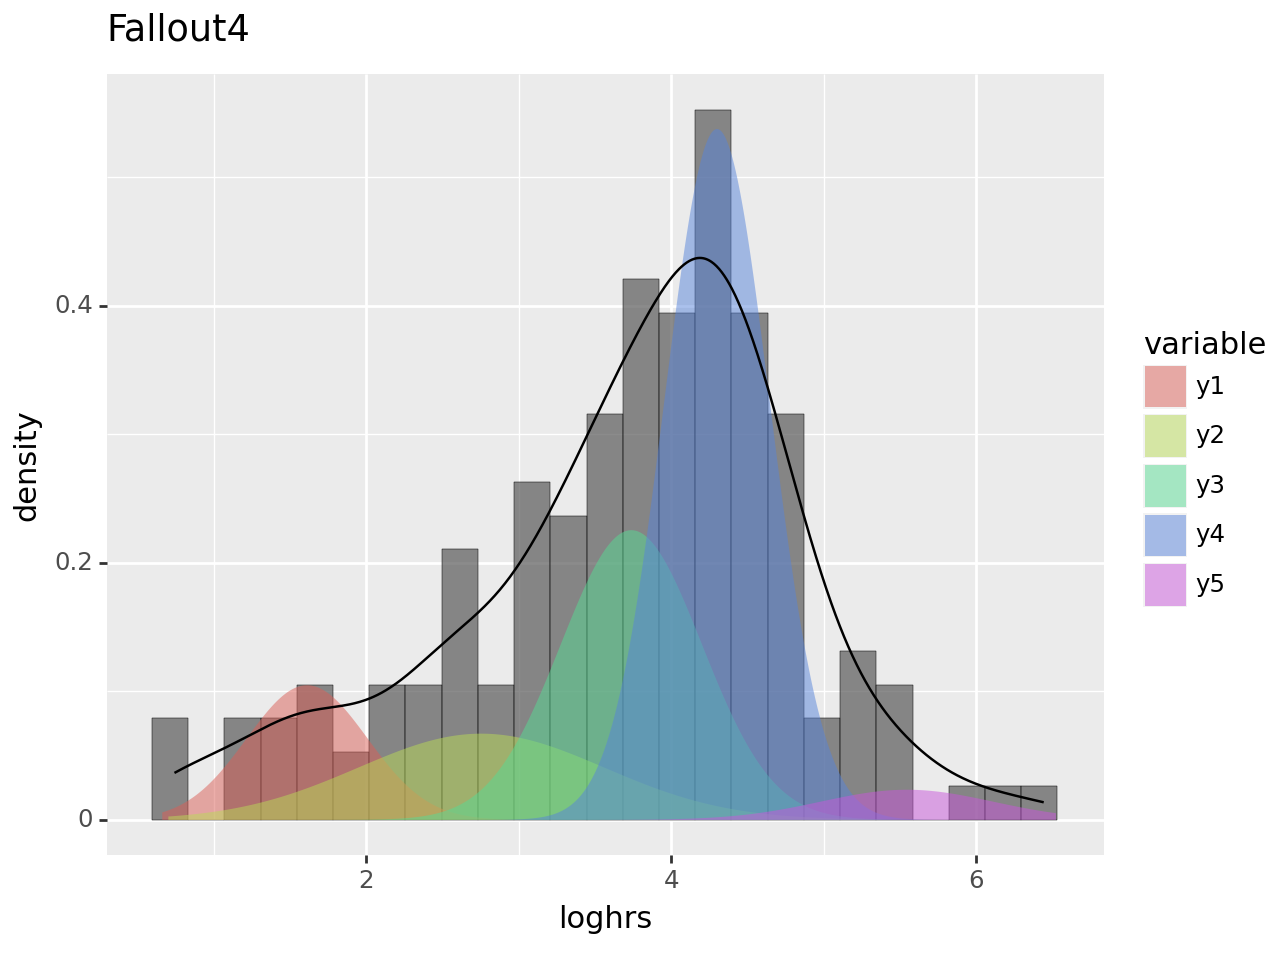


Dimensions of training user-item matrix: (8109, 402)
3.2740121913531692


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:12<00:00,  1.56s/it]

Time difference of 5.206122104326884 mins
     itr         fobj    fobjp      rmse     rmsep
200  201  3147.667137  0.00864  2.151547  0.642323


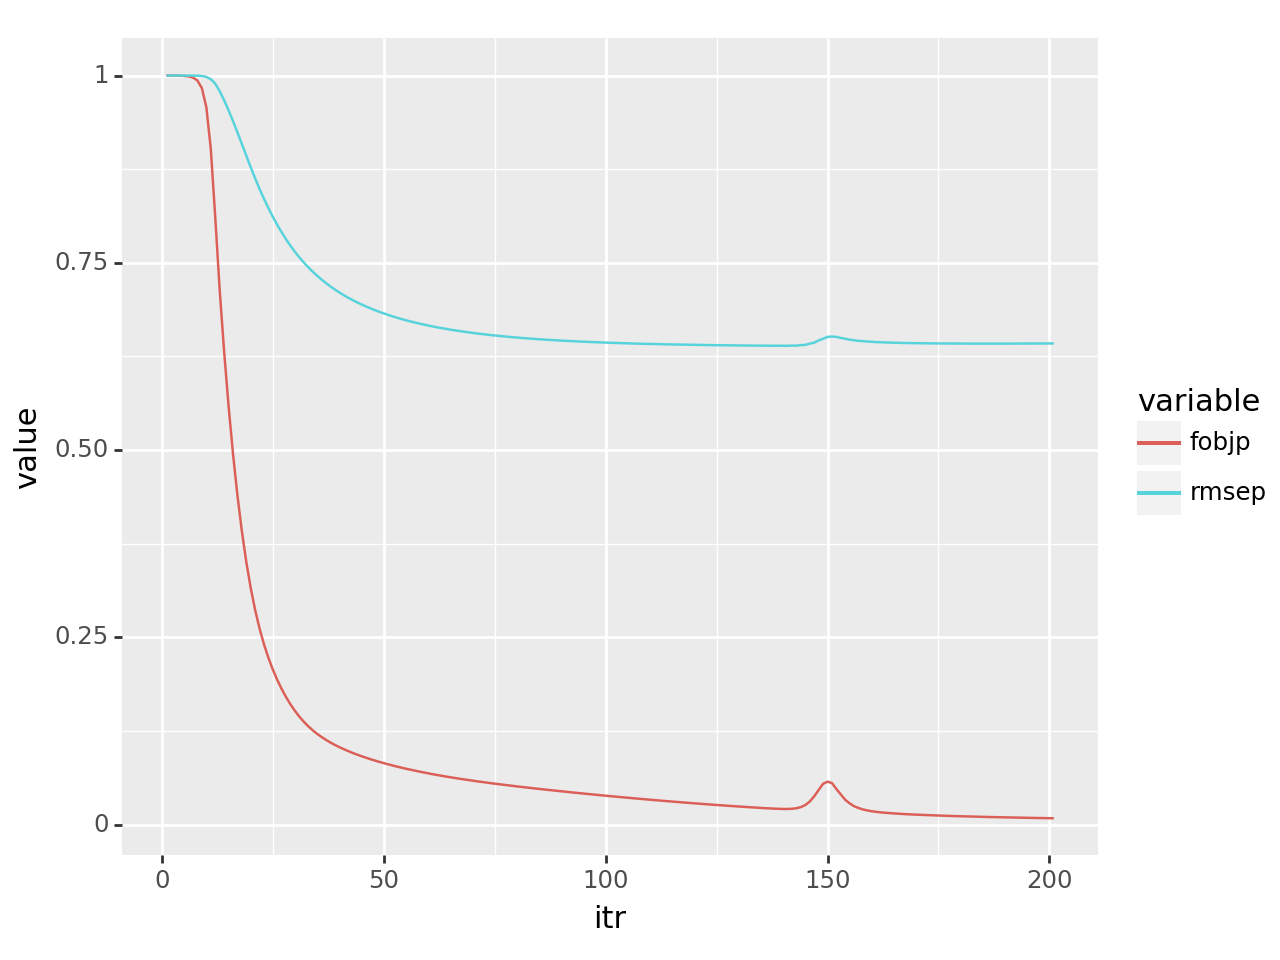

3403it [03:53, 14.57it/s]


In [8]:
## RUN ONLY IF YOU DONT HAVE COLLABORATIVE EM FILE RUNTIME ~10MIN

import pathlib
import pandas as pd
import numpy as np
import re
import scipy
from tqdm import tqdm
import time
from sklearn.mixture import GaussianMixture

steam_clean = pd.read_csv('steam_users_purchase_play.csv')
steam_traind = pd.read_csv('steam_user_train.csv')
steam_test  = pd.read_csv('steam_user_test.csv')

game_freq = steam_traind.groupby(by='game_name').agg({'user_id': 'count', 'hours': 'sum'}).reset_index()

top20 = game_freq.sort_values(by='user_id',ascending=False)[:20].reset_index()


steam_traind['user_id']=steam_traind['user_id'].astype(int)
steam_clean['user_id']=steam_clean['user_id'].astype(int)
steam_test['user_id']=steam_test['user_id'].astype(int)

# Cleaning up the game columns. It doesn't like some of the special characters
steam_traind['game1'] = steam_traind['game_name'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
steam_clean['game1'] = steam_clean['game_name'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
#steam_clean.head()

#EM Algorithm based on raw data
def game_hrs_density(GAME, nclass, print_vals=True):
    #Ignore the game hrs less than 2 hrs
    game_data = steam_clean[(steam_clean['game1'] == GAME)&(steam_clean['hours']>2)]
    #Log hrs
    game_data['loghrs'] = np.log(steam_clean['hours'])
    #Calculate the mu,sigma to process Gaussian function
    mu_init = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), nclass).reshape(-1, 1)
    sigma_init = np.array([1] * nclass).reshape(-1, 1, 1)
    gaussian = GaussianMixture(n_components=nclass, means_init=mu_init, precisions_init=sigma_init).fit(game_data['loghrs'].values.reshape([-1, 1]))
    #print Gaussian Lambda Mean Sigma
    #if print_vals:
    #     print(' lambda: {}\n mean: {}\n sigma: {}\n'.format(gaussian.weights_, gaussian.means_, gaussian.covariances_))
    #Random Generate
    x = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), 1000)
    #Plot
    dens = pd.DataFrame({'x': x})
    for i in range(nclass):
        dens['y{}'.format(i+1)] = gaussian.weights_[i]* scipy.stats.norm(gaussian.means_[i][0], gaussian.covariances_[i][0][0]).pdf(x)
    dens = dens.melt('x', value_name='gaussian')
    # Building data frame for plotting
    game_plt = ggplot(aes(x='loghrs', y='stat(density)'), game_data) + geom_histogram(bins=25, colour = "black", alpha = 0.7, size = 0.1) + \
               geom_area(dens, aes(x='x', y='gaussian', fill = 'variable'), alpha = 0.5, position = position_dodge(width=0.2)) + geom_density()+ \
               ggtitle(GAME)
    return game_plt

#Print one example
a = game_hrs_density('Fallout4', 5, True)
print(a)


# Create user item matrix
np.random.seed(910)
# Delete unnecessary characters
game_freq['game1'] = game_freq['game_name'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
# Only Consider the games have more than 50 users
game_users = game_freq[game_freq['user_id'] > 50]

#For whole dataset
steam_clean_pos = steam_clean[steam_clean['hours'] > 2]
steam_clean_pos_idx = steam_clean_pos['game1'].apply(lambda x: x in game_users['game1'].values)
steam_clean_pos = steam_clean_pos[steam_clean_pos_idx]
steam_clean_pos['loghrs'] = np.log(steam_clean_pos['hours'])


# make matrix
games = pd.DataFrame({'game1': sorted(steam_clean_pos['game1'].unique()), 'game_id': range(len(steam_clean_pos['game1'].unique()))})
users = pd.DataFrame({'user_id': sorted(steam_clean_pos['user_id'].unique()), 'user_ide': range(len(steam_clean_pos['user_id'].unique()))})
steam_clean_pos = pd.merge(steam_clean_pos, games, on=['game1'])
steam_clean_pos = pd.merge(steam_clean_pos, users, on=['user_id'])

ui_mat = np.zeros([len(users), len(games)])
for i in range(steam_clean_pos.shape[0]):
    line = steam_clean_pos.iloc[i]
    ui_mat[line['user_ide'], line['game_id']] = line['loghrs']

#test dataset user
users_test = pd.DataFrame({'user_id': sorted(steam_test['user_id'].unique()), 'user_ide': range(len(steam_test['user_id'].unique()))})
#print(users_test)

# For train dataset
# Only consider the games hrs more than 2 hrs
steam_train = steam_traind[steam_traind['hours'] > 2]
#print(steam_train)
#Not consider the games that users less than 50
steam_train_idx = steam_train['game1'].apply(lambda x: x in game_users['game1'].values)
steam_train = steam_train[steam_train_idx]
steam_train['loghrs'] = np.log(steam_train['hours'])
# Make Matrix
# List the games in train dataset use for recommend
games_train = pd.DataFrame({'game1': sorted(steam_train['game1'].unique()), 'game_id': range(len(steam_train['game1'].unique()))})
# List the users in train dataset use for recommend
users_train = pd.DataFrame({'user_id': sorted(steam_train['user_id'].unique()), 'user_ide': range(len(steam_train['user_id'].unique()))})
#Merge the games and users to one data frame
steam_train = pd.merge(steam_train, games_train, on=['game1'])
steam_train = pd.merge(steam_train, users_train, on=['user_id'])

# Create training set
test=steam_train
ui_train = ui_mat
for i in range(test.shape[0]):
    line = test.iloc[i]
    ui_train[line['user_ide'], line['game_id']] = 0
print("Dimensions of training user-item matrix:", ui_train.shape)

# Root Mean Squared error function, Evaluation metric for SVD
def rmse(pred, test, data_frame=False):
    test_pred = np.array([np.nan] * len(test))
    for i in range(len(test)):
        line = test.iloc[i]
        test_pred[i] = pred[line['user_ide'], line['game_id']]
    if data_frame:
        return pd.DataFrame({'test_pred': test_pred, 'loghrs': test['loghrs']})
    return np.sqrt(1/(len(test)-1)*np.sum((test_pred - test['loghrs']) ** 2))

# Basic svd
Y = pd.DataFrame(ui_train).copy()

# Impute the missing observations with a mean value
means = np.mean(Y, axis=0)  # Calculate mean along columns
for i, col in enumerate(Y.columns):
    Y[col] = Y[col].apply(lambda x: means[i] if x == 0 else x)

U, D, V = np.linalg.svd(Y)
p_df = pd.DataFrame({'x': range(1, len(D)+1), 'y': D/np.sum(D)})

#Set the latent factor as 60
lc = 60
pred = np.dot(np.dot(U[:, :lc], np.diag(D[:lc])), V[:lc, :])
#Calculate rmse
print(rmse(pred, test))
rmse(pred, test, True).head()

#SVD via gradient descent
#Set the latent factor as 60
leading_components=60

# Setting matricies
Y = pd.DataFrame(ui_train)
I = Y.copy()

for col in I.columns:
    I[col] = I[col].apply(lambda x: 1 if x > 0 else 0)
U = np.random.normal(0, 0.01, [I.shape[0], leading_components])
V = np.random.normal(0, 0.01, [I.shape[1], leading_components])
#Squared error
def f(U, V):
    return np.sum(I.values*(np.dot(U, V.T)-Y.values)**2)
def dfu(U):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)), V)
def dfv(V):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)).T, U)

#Gradient descent
N = 200
alpha = 0.001
pred = np.round(np.dot(U, V.T), decimals=2)
fobj = [f(U, V)]
rmsej = [rmse(pred, test)]
start = time.time()
#process iteratively until we get to the bottom
for i in tqdm(range(N)):
    U = U - alpha*dfu(U)
    V = V - alpha*dfv(V)
    fobj.append(f(U, V))
    pred = np.round(np.dot(U, V.T), 2)
    rmsej.append(rmse(pred, test))

print('Time difference of {} mins'.format((time.time() - start) / 60))
#fojb predicted values
fojb = np.array(fobj)
#rmsej actual observed values
rmsej = np.array(rmsej)
path1 = pd.DataFrame({'itr': range(1, N+2), 'fobj': fobj, 'fobjp': fobj/max(fobj), 'rmse': rmsej, 'rmsep': rmsej/max(rmsej)})
path1gg = pd.melt(path1[["itr", "fobjp", "rmsep"]], id_vars=['itr'])
print(path1.tail(1))

print(ggplot(path1gg, aes('itr', 'value', color = 'variable')) + geom_line())


# Export recommend games
user_dict = dict(users.values)
game_dict = {games.iloc[i, 0]: games.iloc[i, 1] for i in range(games.shape[0])}
I_pred = np.zeros_like(I)
for i in range(steam_clean.shape[0]):
    line = steam_clean.iloc[i]
    if line['user_id'] in user_dict and line['game1'] in game_dict:
        I_pred[user_dict[line['user_id']], game_dict[line['game1']]] = 1

reverse_game_dict = {games.iloc[i, 1]: games.iloc[i, 0] for i in range(games.shape[0])}
pred_percentile = pd.DataFrame(pred)
for col in pred_percentile.columns:
    pred_percentile[col] = pred_percentile[col].rank(pct=True)
pred_percentile = pred_percentile.values


def top(n, user, print_value=True):
    #Not consider the games has been purchsed
    not_purchased = (I - 1) % 2
    t_user = user
    user = user_dict[user]
    top_games = (pred_percentile*not_purchased).iloc[user]
    top_games = list(top_games.sort_values(ascending=False)[:20].index)
    #For test
    if print_value:
        print('top {} recommended games for user {}: '.format(n, t_user))
        for i in range(n):
            print(i, ")", reverse_game_dict[top_games[i]])
    else:
        result = [t_user]
        for i in range(n):
            result.append(reverse_game_dict[top_games[i]])
        return result

top_N = 20
result = []
users_merge=pd.merge(users_test,users_train,on='user_id',how='inner')
for idx, user in tqdm(enumerate(users_merge['user_id'].values)):
    result.append(top(top_N, user, False))

users_not=users_test[~users_test['user_id'].isin(users_merge['user_id'])]
for user in users_not['user_id']:
    empty=[user]
    for i in range(20):
        empty.append(0)
    result.append(empty)
df = pd.DataFrame(result)
columns = ['user_ide'] + ['{}'.format(i+1) for i in range(top_N)]
df.columns = columns
df.to_csv('Collaborative_EM_output.csv', index=None)

# Identify the top 20 most played games by hours
top_20_most_played = game_freq.sort_values(by='hours', ascending=False).head(20)

# Read the existing content of the file
with open('Collaborative_EM_output.csv', 'r') as file:
    existing_content = file.readlines()

# Prepare the new first line
new_first_line = ', '.join(top_20_most_played['game_name'].tolist()) + '\n'

# Write the new first line and the existing content back to the file
with open('Collaborative_EM_output.csv', 'w') as file:
    file.write(new_first_line)
    file.writelines(existing_content)


In [4]:
## RUN TO INITIALISE FUNCTIONS FOR CONTENT BASED 

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pathlib

# Load the datasets
dataGames = pd.read_csv('reduced_cleaned_usedGames.csv')
dataUsers = pd.read_csv('steam_user_train.csv')
dataReviews = pd.read_csv('steam_games_reviews.csv', usecols=["name", "percentage_positive_review"])

# Construct a reverse map of indices and game names
indices = pd.Series(dataGames.index, index=dataGames['name']).drop_duplicates()

n_recommendation = 20
col_names = ["user_id"] + list(map(str, range(1, n_recommendation + 1)))

def get_recommendations(title, cosine_sim, indices):
    if title not in indices.index:
        return []

    idx = indices[title]
    if isinstance(idx, pd.Series):
        return []

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendation + 1]

    game_indices = [i[0] for i in sim_scores]
    return dataGames['name'].iloc[game_indices].tolist()

def make_recommendation_for_user(user_id, game_list, game_user_have):
    if not game_list:
        return pd.DataFrame(data=[[user_id] + [""] * n_recommendation], columns=col_names)

    recommendation_reviews = dataReviews[dataReviews['name'].isin(game_list)]
    recommendation_reviews = recommendation_reviews[~recommendation_reviews['name'].isin(game_user_have)]
    recommendation_reviews = recommendation_reviews.sort_values(by="percentage_positive_review", ascending=False)

    if len(recommendation_reviews) < n_recommendation:
        return pd.DataFrame(data=[[user_id] + recommendation_reviews["name"].tolist() +
                                  [""] * (n_recommendation - len(recommendation_reviews))],
                            columns=col_names)
    else:
        return pd.DataFrame(data=[[user_id] + recommendation_reviews["name"].tolist()[0:n_recommendation]],
                            columns=col_names)

def get_recommendations_for_single_user(user_id, column_name, dataGames, dataUsers, dataReviews, indices):
    recommendationByUserData = pd.DataFrame(columns=col_names)

    # Ensure the column is free of NaN values
    dataGames[column_name] = dataGames[column_name].fillna('')

    # Compute the Cosine Similarity matrix
    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(dataGames[column_name])
    cosine_sim_matrix = cosine_similarity(count_matrix, count_matrix)

    # Get the games for the specified user
    user_games = dataUsers[dataUsers['user_id'] == user_id]['game_name'].tolist()

    # Generate recommendations
    listSuggestion = [game for game in user_games if game in indices.index]
    listSuggestion = [item for sublist in listSuggestion for item in get_recommendations(sublist, cosine_sim_matrix, indices)]
    recommendationByUserData = make_recommendation_for_user(user_id, listSuggestion, user_games)

    return recommendationByUserData



## Neural

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Load game data
dataGames = pd.read_csv(('steam_games.csv'))

# Just the ids and names of the games
all_game_names = dataGames['name'].unique().tolist()


# Load your dataset
dataUsers = pd.read_csv('steam-200k.csv', header=None, names=['user_id', 'game_name', 'behavior', 'value', 'zero'])
dataUsers = dataUsers[dataUsers['behavior'] == 'play']
dataUsers.drop(['behavior', 'zero'], axis=1, inplace=True)
dataUsers['user_id'] = dataUsers['user_id'].astype('category').cat.codes
dataUsers['game_name'] = dataUsers['game_name'].astype('category').cat.codes

# Normalize  
scaler = MinMaxScaler()
dataUsers['value'] = scaler.fit_transform(dataUsers[['value']])

# Splitting the dataset
X = dataUsers[['user_id', 'game_name']].values
y = dataUsers['value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Updated Model Architecture
number_users = dataUsers['user_id'].nunique()
number_games = dataUsers['game_name'].nunique()
number_factors = 100
n_neurons = 128

user_input = Input(shape=(1,), name='user_input')
game_input = Input(shape=(1,), name='game_input')

user_embedding = Embedding(output_dim=number_factors, input_dim=number_users, input_length=1, name='user_embedding')(user_input)
game_embedding = Embedding(output_dim=number_factors, input_dim=number_games, input_length=1, name='game_embedding')(game_input)

user_vector = Flatten(name='flatten_users')(user_embedding)
game_vector = Flatten(name='flatten_games')(game_embedding)

concat = Concatenate()([user_vector, game_vector])

dense = Dense(n_neurons, activation='relu')(concat)
dropout = Dropout(0.5)(dense)
dense_2 = Dense(n_neurons // 2, activation='relu')(dropout)
output = Dense(1)(dense_2)

model_cf = Model(inputs=[user_input, game_input], outputs=output)
model_cf.compile(optimizer=Adam(0.001), loss='mean_squared_error')



# Training the model

In [3]:
# Training the model
history_cf = model_cf.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=100, validation_split=0.1)

model_cf.save('my_model.h5')
# Plotting training and validation loss
plt.plot(history_cf.history['loss'], label='Training Loss')
plt.plot(history_cf.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()



# Load the model from the file

In [ ]:
from tensorflow.keras.models import load_model

model_cf = load_model('my_model.h5')  


# Testing

In [5]:

y_pred = model_cf.predict([X_test[:, 0], X_test[:, 1]])

# Calculating RMSE, Test MSE, and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Test Mean Squared Error (MSE): {test_mse}')
print(f'R-squared (R2): {r2}')


441/441 [==============================] - 1s 1ms/step
Root Mean Squared Error (RMSE): 0.020578407313596562
Test Mean Squared Error (MSE): 0.0004234708475642845
R-squared (R2): 0.029686240842518252


# Ploting

In [1]:
# Plot training loss
plt.plot(history_cf.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss - Training')
plt.legend()
plt.show()

# Plot validation loss
plt.plot(history_cf.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss - Validation')
plt.legend()
plt.show()

# Model summary
model_cf.summary()

# Visualizing

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Visualize embeddings using PCA
user_em_weights = model_cf.get_layer('user_embedding').get_weights()[0]
game_em_weights = model_cf.get_layer('game_embedding').get_weights()[0]

pca = PCA(n_components=2)
pca_result_user = pca.fit_transform(user_em_weights)
pca_result_game = pca.fit_transform(game_em_weights)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_result_user[:, 0], y=pca_result_user[:, 1])
plt.title('User Embeddings - PCA')

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_result_game[:, 0], y=pca_result_game[:, 1])
plt.title('Game Embeddings - PCA')

plt.show()

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tnse_results_user = tsne.fit_transform(user_em_weights)
tnse_results_game = tsne.fit_transform(game_em_weights)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tnse_results_user[:, 0], y=tnse_results_user[:, 1])
plt.title('User Embeddings - t-SNE')

plt.subplot(1, 2, 2)
sns.scatterplot(x=tnse_results_game[:, 0], y=tnse_results_game[:, 1])
plt.title('Game Embeddings - t-SNE')

plt.show()

In [2]:
def make_recommendations(model, user_id, user_game_interactions, all_game_names, top_n=20):
    
    # Find the encoded user ID
    user_game_interactions['user_id_encoded'] = user_game_interactions['user_id'].astype('category').cat.codes
    user_game_interactions['game_id_encoded'] = user_game_interactions['game_name'].astype('category').cat.codes
    user_id_encoded = user_game_interactions[user_game_interactions['user_id'] == user_id]['user_id_encoded'].iloc[0]

    # Items already interacted with by the user
    interacted_items = user_game_interactions[user_game_interactions['user_id_encoded'] == user_id_encoded]['game_id_encoded'].tolist()

    # Items not interacted with by the user
    non_interacted_items = set(user_game_interactions['game_id_encoded'].unique()) - set(interacted_items)

    # Predict scores for non-interacted items
    user_encoded_array = np.array([user_id_encoded] * len(non_interacted_items))
    item_encoded_array = np.array(list(non_interacted_items))
    predicted_scores = model.predict([user_encoded_array, item_encoded_array])

    # Sort the items based on predicted scores
    sorted_scores = sorted(zip(non_interacted_items, predicted_scores.ravel()), key=lambda x: x[1], reverse=True)

    # Convert top-N recommendations back to game names
    game_id_to_name = dict(zip(user_game_interactions['game_id_encoded'], user_game_interactions['game_name']))
    top_n_recommendations = [game_id_to_name[item_id] for item_id, _ in sorted_scores[:top_n]]

    return top_n_recommendations

def get_user_recommendations(user_id):
    top_recommendations = make_recommendations(model_cf, user_id, train_dataUsers, all_game_names, top_n=20)
    return top_recommendations

def neural_network_main():
    print("Welcome to the Neural Network Game Recommender System")
    while True:
        user_input = input("Enter a user ID to get recommendations (or 'back' to go back): ")
        if user_input.lower() == 'back':
            break
        try:
            user_id = int(user_input)
            recommendations = get_user_recommendations(user_id)
            print(f"Top recommendations for user {user_id}:")
            for idx, game in enumerate(recommendations, start=1):
                print(f"{idx}. {game}")
        except ValueError:
            print("Please enter a valid user ID.")


In [8]:
import pandas as pd

def main_interface():
    while True:
        print("Welcome to Game Recommendation System")
        print("Press the button displayed to choose how you want to proceed:")
        print("1) Choose recommender.")
        print("2) Quit.")
        choice = input("Enter your choice: ")
        
        if choice == "1":
            print("1) Collaborative_EM")
            print("2) Content Based")
            print("3) NeuralNetwork")
            print("4) Quit")
            recommender_choice = input("Enter your choice: ")
            
            if recommender_choice == "1":
                user_id = input("Enter user ID: ")
                recommended_games = recommend_games(int(user_id))
                print(f"Recommended games for User {user_id}:Games:")
                for idx, game in enumerate(recommended_games, start=1):
                    print(f"{idx}. {game}")
                    
            elif recommender_choice == "2":
                main()  # This function uses the content-based approach
                        #CONTENT BASED NEEDS A VALID USER ID TO NOT PRINT BLANK .
                
            elif recommender_choice == "3":
                neural_network_main()
                
            elif recommender_choice == "4":
                break
            else:
                print("Invalid choice. Please enter a valid number.")

        elif choice == "2":
            break
        else:
            print("Invalid choice. Please enter a valid number.")

def recommend_games(user_id):
    # Load the Collaborative_EM_output.csv file
    df = pd.read_csv('Collaborative_EM_output.csv', skiprows=1)  # Skip the first line
    
    # Load the first line (most played games)
    with open('Collaborative_EM_output.csv', 'r') as file:
        most_played_games = file.readline().strip().split(', ')

    # Check if the user is in the dataset
    if user_id in df['user_ide'].values:
        user_row = df[df['user_ide'] == user_id]
        recommended_games = user_row.iloc[0, 1:].tolist()  # Get the top 20 games for this user
    else:
        recommended_games = most_played_games[:20]  # Return the 20 most played games

    return recommended_games

def display_recommendations(recommendations_df, basis):
    if recommendations_df.empty or recommendations_df.iloc[0, 1:].isnull().all():
        print(f"No recommendations available for user.")
        return

    user_id = recommendations_df.iloc[0, 0]
    recommended_games = recommendations_df.iloc[0, 1:].dropna().tolist()

    print(f"Recommended games based on {basis} for user: {user_id}")
    print("Games:")
    for idx, game in enumerate(recommended_games, start=1):
        print(f"{idx}. {game}")

def get_user_input():
    try:
        user_id = int(input("Please enter your user ID: "))
        print("\nChoose the basis for game recommendations:")
        print("1. Genre and Publisher")
        print("2. Genre and Popular Tags")
        print("3. Genre, Popular Tags, and Game Details")
        print("4. Genre, Publisher, Developer, and Game Details")
        choice = int(input("Enter your choice (1-4): "))

        if choice not in range(1, 5):
            print("Invalid choice. Please enter a number between 1 and 4.")
            return None, None

        return user_id, choice
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        return None, None

def main():
    user_id, choice = get_user_input()
    if user_id is None or choice is None:
        return

    basis_dict = {
        1: ('genre_publisher', 'Genre and Publisher'),
        2: ('genre_popular_tags', 'Genre and Popular Tags'),
        3: ('genre_popular_tags_game_details', 'Genre, Popular Tags, and Game Details'),
        4: ('genre_publisher_developer_game_details', 'Genre, Publisher, Developer, and Game Details'),
    }

    column_name, basis = basis_dict[choice]
    recommendations = get_recommendations_for_single_user(user_id, column_name, dataGames, dataUsers, dataReviews, indices)
    display_recommendations(recommendations, basis)

if __name__ == "__main__":
    main_interface()

Welcome to Game Recommendation System
Press the button displayed to choose how you want to proceed:
1) Choose recommender.
2) Quit.
Enter your choice: 1
1) Collaborative_EM
2) Content Based
3) NeuralNetwork
4) Quit
Enter your choice: 1
Enter user ID: 6717871
Recommended games for User 6717871:Games:
1. MarvelHeroes2015
2. SaintsRowIV
3. BioShockInfinite
4. HeroesGenerals
5. PAYDAYTheHeist
6. DontStarveTogetherBeta
7. SidMeiersCivilizationV
8. FEAR3
9. OrcsMustDie2
10. TheBindingofIsaac
11. SuperMeatBoy
12. Warface
13. BlacklightRetribution
14. SakuraClicker
15. 7DaystoDie
16. AgeofEmpiresIIICompleteCollection
17. Darksiders
18. Fallout4
19. TheWitcher3WildHunt
20. Defiance
Welcome to Game Recommendation System
Press the button displayed to choose how you want to proceed:
1) Choose recommender.
2) Quit.
Enter your choice: 2
